In [26]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from models.DCGAN.constants import *

from glob import glob
import os

import torch
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim

from models.DCGAN.generator import Generator
from models.DCGAN.discriminator import Discriminator

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device))
PATH = "./models/DCGAN/saved_models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [51]:
img_paths = []
for class_path in [os.path.join(dataroot,class_name) for class_name in os.listdir(dataroot)]:
    
    class_img_paths = glob(class_path+"/*")
    for class_img_path in class_img_paths:
        img_paths.append(class_img_path)

print("There are {} style images in Van Gogh Paintings Dataset".format(len(img_paths)))

There are 2025 style images in Van Gogh Paintings Dataset


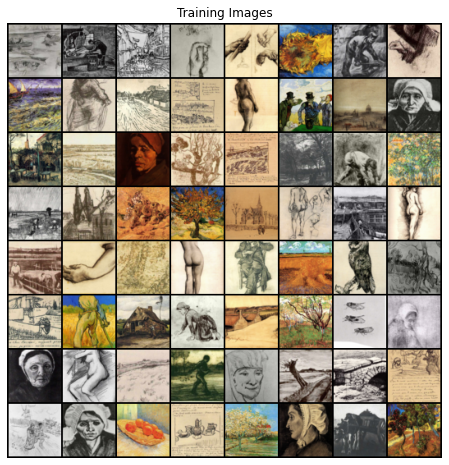

In [68]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [69]:
# weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [70]:
net_g = Generator(1).to(device)
net_g.cuda()
net_g.apply(weights_init)

print(net_g)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [71]:
net_d = Discriminator(1).to(device)
net_d.cuda()
net_d.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [72]:
if (os.path.exists(f"{PATH}/net_g")):
    net_g.load_state_dict(torch.load(f"{PATH}/net_g"))
if (os.path.exists(f"{PATH}/net_d")):
    net_d.load_state_dict(torch.load(f"{PATH}/net_d"))

In [73]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizer_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))

In [74]:
f = open("./models/DCGAN/losses.txt", "a")
f.write("Losses log for DCGAN\n")

21

In [75]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
print(str(num_epochs))
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        net_d.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = net_d(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = net_g(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = net_d(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizer_d.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        net_g.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = net_d(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizer_g.step()

        # Output training stats
        if i % 50 == 0:
            log_str = ('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            print(log_str)
            f.write(f"{log_str}\n") # write to the log file
            f.flush()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_g(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
f.close()

Starting Training Loop...
100
[0/100][0/16]	Loss_D: 0.9018	Loss_G: 6.0456	D(x): 0.7579	D(G(z)): 0.3695 / 0.0161
[1/100][0/16]	Loss_D: 1.1244	Loss_G: 1.9471	D(x): 0.4470	D(G(z)): 0.1330 / 0.2109
[2/100][0/16]	Loss_D: 1.2595	Loss_G: 2.1047	D(x): 0.3900	D(G(z)): 0.0705 / 0.1553
[3/100][0/16]	Loss_D: 1.0836	Loss_G: 1.4426	D(x): 0.5247	D(G(z)): 0.2395 / 0.2762
[4/100][0/16]	Loss_D: 0.6898	Loss_G: 2.5033	D(x): 0.6764	D(G(z)): 0.1936 / 0.1008
[5/100][0/16]	Loss_D: 0.9822	Loss_G: 3.5295	D(x): 0.7328	D(G(z)): 0.4559 / 0.0357
[6/100][0/16]	Loss_D: 0.5657	Loss_G: 4.5487	D(x): 0.8778	D(G(z)): 0.3314 / 0.0140
[7/100][0/16]	Loss_D: 0.6080	Loss_G: 2.4516	D(x): 0.7594	D(G(z)): 0.2579 / 0.0965
[8/100][0/16]	Loss_D: 0.5078	Loss_G: 3.5525	D(x): 0.8726	D(G(z)): 0.2755 / 0.0443
[9/100][0/16]	Loss_D: 0.6592	Loss_G: 4.1257	D(x): 0.7996	D(G(z)): 0.3153 / 0.0236
[10/100][0/16]	Loss_D: 0.7716	Loss_G: 7.7592	D(x): 0.9267	D(G(z)): 0.4618 / 0.0008
[11/100][0/16]	Loss_D: 0.4301	Loss_G: 4.3596	D(x): 0.8869	D(G(z)): 

[99/100][0/16]	Loss_D: 0.4231	Loss_G: 3.0890	D(x): 0.7980	D(G(z)): 0.1422 / 0.0691


In [76]:
torch.save(net_g.state_dict(), f"{PATH}/net_g")
torch.save(net_d.state_dict(), f"{PATH}/net_d")

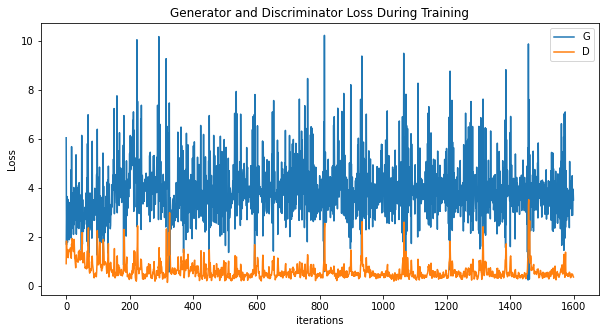

In [77]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

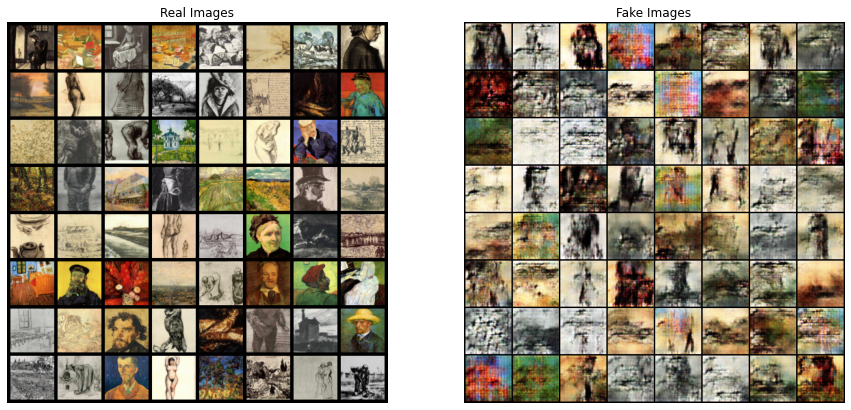

In [78]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()